## Explaining Graph Neural Networks

Explainability in AI refers to the ability of AI models, especially complex ones like deep learning models, to provide **understandable**, **interpretable**, and **transparent** explanations for their decisions and predictions. In other words, it aims to make the "black box" of AI more transparent, so that humans can understand why an AI system made a particular choice.

In GNNs, information propagates across the graph, meaning that decisions are often influenced by distant nodes or multi-hop neighbors. *Explaining which nodes and paths influenced a specific prediction can be complex.* Explaining GNNs is a new field that takes a lot of ideas from other explainable AI (XAI) methods.Different explanation methods exist to understand how and why a GNN made a specific prediction. These techniques will help us see which nodes, edges, or features in the graph were most important in influencing the decision, making it easier to interpret the model's reasoning.

Key aspects we try to explain in GNN include:

- Feature Importance: Which node features (attributes) are most important in determining the node’s prediction? For instance, if we are predicting the role of a user in a social network, what aspects of the user (e.g., number of connections, user behavior) contributed most to the prediction?

- Neighborhood Influence: Which neighboring nodes and their features played a significant role in the prediction? GNNs aggregate information from nearby nodes, so understanding how the local structure and neighbors influenced the target node is crucial.

- Why was this edge predicted?: What aspects of the two connected nodes, their features, and their relationships (e.g., common neighbors or structural similarity) made the GNN predict that an edge should exist between them? For example, in a social network, why the GNN predicted a friendship link between two users? The explanation might reveal common friends, shared interests, or similar activity patterns as the reasons behind the prediction.

### GNNExplainer

GNNExplainer is a technique that helps understand the decisions made by a Graph Neural Network (GNN). It aims to provide clear explanations for the predictions of GNNs by identifying which parts of the graph (nodes, edges, and their features) are most important for a particular prediction.

Introduced in 2019, GNNExplainer is a method for explaining predictions made by another Graph Neural Network (which is already trained). Graph data requires us to identify which nodes and features are most influential. GNNExplainer provides explanations by highlighting a smaller subgraph and specifying which node features were key to the prediction. The figure below shows an example of what GNNExplainer's explanation looks like for a specific node:
<center><img src="images/explainer_illustration.png", width=400></center>
<center><small>image from Labonne, Maxime. "Hands-On Graph Neural Networks Using Python: Practical techniques and architectures for building powerful graph and deep learning apps with PyTorch". Packt Publishing Ltd, 2023.</small></center>


Problem setup: 

- Let Graph $G$ be a graph with nodes $V$ and edges $E$. Nodes are associated with $d$-dimensional features. The feature matrix $X$ is defined as $X = \{x_1, \ldots, x_n\}$, where $x_i \in \mathbb{R}^d$ is the feature vector for node $i$. Here, $n$ is the number of nodes in the graph, and $d$ is the dimensionality of the node features.

- We are specifically interested in explaining the predictions made for a **node classification** task. In this task, each node $v \in V$ is mapped to a class label $f(v) \in \{1, \ldots, C\}$, where $C$ is the number of possible classes.

- Let $\Phi$ be a Graph Neural Network model optimized on the training set of nodes. The model $\Phi$ approximates the label function $f$ for predicting the class of new nodes.

GNNExplainer aims to provide an explanation for the predictions made by the trained GNN model $\Phi$. Specifically, it tries to identify **a subgraph $G_S$** and a **subset of node features $X_S$** that are most influential in determining the model's prediction for a particular node $v$.

> **Key Idea: Importance Determination:**  \
> If removing an edge or feature significantly changes the prediction, that edge or feature is considered important. If the prediction remains the same, the edge or feature is less important.

GNNExplainer measures the importance of edges and features by evaluating the *mutual information* between the prediction and the masked subgraph:

\begin{equation*}
MI = I(Y;\hat{Y})=H(Y|G,X)-H(Y|G_S,X_S)
\end{equation*}

where $Y$ is the label matrix predicted by the original trained model $\Phi$ and $\hat{Y}$ is the label matrix predicted on the masked graph and features $(G_S,X_S)$.

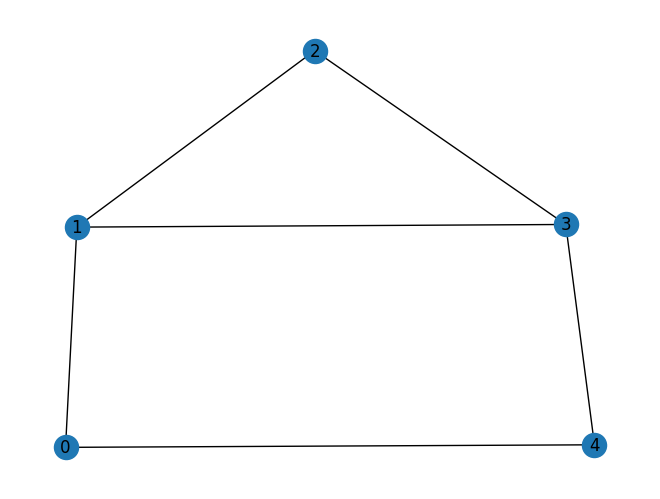

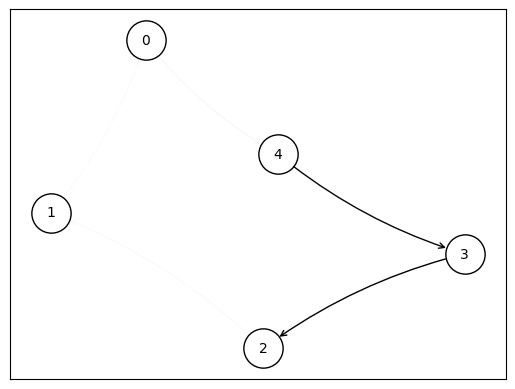

tensor([0.0574, 0.0602, 0.9548, 0.9328, 0.0687, 0.0432])


In [19]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.explain import Explainer, GNNExplainer
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# 1. Create a Small Synthetic Graph
edge_index = torch.tensor([
    [0, 1, 2, 3, 4, 1],
    [1, 2, 3, 4, 0, 3]
], dtype=torch.long)

# 5 nodes, 2 features per node
x = torch.tensor([
    [1, 0],
    [0, 1],
    [1, 1],
    [0, 0],
    [1, 0]
], dtype=torch.float)

# Labels for node classification
y = torch.tensor([0, 1, 0, 1, 0], dtype=torch.long)

# Create the data object
data = Data(x=x, edge_index=edge_index, y=y)

G = nx.Graph()
G.add_nodes_from(range(5))
G.add_edges_from(list(map(lambda x: (x[0].item(),x[1].item()),edge_index.T)))
nx.draw(G,with_labels=True)
plt.show()
# 2. Define a Simple GNN Model
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(2, 4)
        self.conv2 = GCNConv(4, 2)
    
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

model = GCN()

# 3. Train the GNN on the Graph
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in range(100):
    optimizer.zero_grad()
    out = model(data.x,data.edge_index)
    loss = F.nll_loss(out, data.y)
    loss.backward()
    optimizer.step()

# 4. Initialize GNNExplainer
explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='log_probs',
    ),
)
fig = plt.figure()
explanation = explainer(data.x, data.edge_index)
explanation.visualize_graph()
plt.show()
print(explanation.edge_mask)


